In [13]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
import fiona

from shapely.geometry import Point

from geopy.geocoders import Nominatim

### This is the solution I would have first guessed -- seems to work fine for small samples.

In [14]:
a = gpd.tools.geocode(["Philadelphia", "Chicago", "Ann Arbor", "Paris", "Hong Kong"])
b = gpd.tools.geocode(["Chicago", "Ann Arbor"])

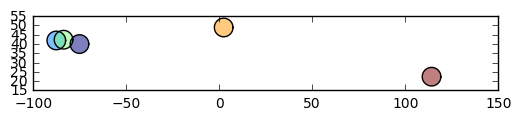

In [15]:
a.set_geometry(a.buffer(5), inplace = True)
a.plot()

In [16]:
a.contains(b.ix[1].geometry)

0    False
1     True
2     True
3    False
4    False
dtype: bool

In [17]:
j = gpd.sjoin(a, b)
j.groupby("index_right")["address_left"].count()

,address_left,geometry,index_right,address_right
1,"Chicago, IL, USA","POLYGON ((-82.6297982 41.8781136, -82.65387456...",0,"Chicago, IL, USA"
2,"Ann Arbor, MI, USA","POLYGON ((-78.7430378 42.2808256, -78.76711416...",0,"Chicago, IL, USA"
1,"Chicago, IL, USA","POLYGON ((-82.6297982 41.8781136, -82.65387456...",1,"Ann Arbor, MI, USA"
2,"Ann Arbor, MI, USA","POLYGON ((-78.7430378 42.2808256, -78.76711416...",1,"Ann Arbor, MI, USA"


### Import Station Dataframe and Build GeoDataFrame

In [6]:
stations = pd.read_csv("stations.csv")
stations.dropna(inplace = True)

station_locations = [Point(xy) for xy in zip(stations["FROM LONGITUDE"], stations["FROM LATITUDE"])]
geo_stations = gpd.GeoDataFrame(stations, geometry = station_locations)
geo_stations.crs = fiona.crs.from_epsg(3528)

geo_stations.set_geometry(geo_stations.buffer(0.003), inplace = True)

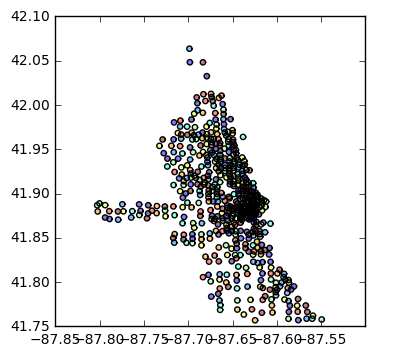

In [7]:
geo_stations.plot()

### Import Crimes and Build GeoDataFrame

In [10]:
crimes = pd.read_csv("crimes.csv", usecols = [19, 20])
crimes.dropna(inplace = True)

crime_locations = [Point(xy) for xy in zip(crimes["Longitude"], crimes["Latitude"])]
geo_crimes = gpd.GeoDataFrame(crimes, geometry = crime_locations)
geo_crimes.crs = fiona.crs.from_epsg(3528)

### This runs within a few minutes.

In [11]:
j = gpd.sjoin(geo_crimes, geo_stations)

In [12]:
j.groupby("index_right")["FROM STATION ID"].count()

index_right
2       131
3        24
4         7
6      1908
7        76
8       796
9       373
10     1815
11      635
12      521
13      379
14      456
15      478
16      501
17      697
18      370
19      778
20      485
21      375
22      569
23     1196
24     3156
25      784
26      256
27      217
28      391
29      524
30     1030
31      194
32     3032
       ... 
485    1993
486     567
487    1547
488     883
489    2638
490    2902
491     575
492    1468
493    1639
494     835
495    1640
496      73
497     132
498      35
499     414
500     815
501     281
502     556
503     891
504     348
505     867
506     521
507     750
508     321
509    1286
510     994
511    1295
512     408
513     578
514     409
Name: FROM STATION ID, dtype: int64

### Loop over stations: somewhat slower.
This took around 40 minutes on my computer with 1M crimes (consider grepping to serious crimes to make it faster!).
I don't see how to make it faster, since you're doing a million checks 500 times -- it's a hefty processing.

In [ ]:
with open("station_count.csv", "w") as out:
    for ix, s in geo_stations.iterrows():
        
        count = geo_crimes[geo_crimes.within(s.geometry)]["Latitude"].count()
        s = "{},{}".format(s["FROM STATION ID"], count)
        print(s)
        out.write(s + "\n")

### Looping over crimes seems slower.

In [ ]:
geo_stations["Crime Count"] = 0
for ix, c in geo_crimes.iterrows():
    geo_stations["Crime Count"] += geo_stations.contains(c.geometry)